# Исследование данных о продажах игр

Нужно провести анализ продаж игр и определенить тренды развития игровой индустрии как в общем, так и для конкретных мест.

## Описание данных
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## План работы

- Шаг 1. Откройте файл с данными и изучите общую информацию
- Шаг 2. Подготовьте данные
- Шаг 3. Проведите исследовательский анализ данных
- Шаг 4. Составьте портрет пользователя каждого региона
- Шаг 5. Проверьте гипотезы
- Шаг 6. Напишите общий вывод

In [266]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

### Шаг 1. Откройте файл с данными и изучите общую информацию

In [267]:
games = pd.read_csv('/datasets/games.csv')

In [269]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Вывод

В данном шаге мы открыли файлы с данными, просмотрели их на предмет пропусков и типов данных. В следующем шаге будем исправлять проблемы, имеющиеся в данных (очевидно неправильный тип данных у `User_Score` или подозрительные два пропуска в столбце `Name` и `Genre`, они наверняка могут быть связаны). Учитывая, что в столбцах `Name` и `Genre` пропущенно всего 2 значения, вероятно, это мог быть технический брак. Пропуски в столбцах `Critic_Score` и `User_Score` могут быть вызваны тем, что нет центролизованной системы сбора оценок от экпертов и пользователей, засчет этого многие игры не имеют оценок. Пропуски в столбце `Rating` могут быть вызваны тем, что на момент выхода игры, рейтинги им еще не присваивались.

### Шаг 2. Подготовьте данные

- Замените названия столбцов (приведите к нижнему регистру);

In [270]:
games.columns = [i.lower() for i in games.columns]

- Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;

Чтобы заменить тип данных в столбце `year_of_release`(float на int), нужно устранить все пропуски. Для этого подсчитаем средний год для каждой платформы(у каждой платформы есть определенный "срок жизни", игры на одну и ту же платформу 20 лет подряд выпускать не будут, поэтому такая оценка года выпуска игры на определенную платформу может быть приближена к реальности)

In [271]:
#подсчитаем средний год для каждой платформы
platform_year = games.groupby('platform')['year_of_release'].mean().apply(round)

In [272]:
#список из всех платформ
platforms_type = games['platform'].unique()

In [273]:
#замена пропусков значениями из platform_year
for i in platforms_type:
    games.loc[(pd.isna(games['year_of_release'])==True) & (games['platform'] == i), 'year_of_release'] = platform_year[i]

In [274]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Теперь можем заменить тип данных в стоблце `year_of_release`.

In [275]:
games['year_of_release'] = games['year_of_release'].astype('int')

В столбцах `critic_Score`, `user_Score`, `rating` пропуски останутся на своих местах, так как не вижу данных, по которым можно было бы близко к достоверному оценить значения этих пропусков. Поэтому и тип данных в этих столбцах(кроме `user_score`) изменить тоже не получится.

Посмотрим на пропуски в столбце Name

In [276]:
games[pd.isna(games['name']) == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В этих данных нет названия игр, жанра, оценок и рейтинга. Слишком много пропущенных данных, считаю, что пользы эти данные не принесут и их надо удалить.

In [277]:
games = games.loc[pd.isna(games['name']) == False,:]

В столбце `user_score` кроме оценок и NaN имеется значение tbd, что означает to be announced - 'будет объявлено дополнительно'. По факту имеем отсутствие оценки, поэтому заменим tbd на NaN.

In [278]:
NaN = np.nan
games.loc[games['user_score'] == 'tbd', 'user_score'] = NaN

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


И теперь изменим тип данных в `user_score`.

In [279]:
games['user_score'] = pd.to_numeric(games['user_score'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


- Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [280]:
games['sum_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Вывод

В данном пункте были:
- приведены к нижнему регистру названия столбцов
- заполнены пропуски в столбце `platform`
- заменен тип данных в столбцах `year_of_release` и `user_score`
- создан столбец `sum_sales`, который равен сумме продаж во всех регионах.

### Шаг 3. Проведите исследовательский анализ данных

- Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

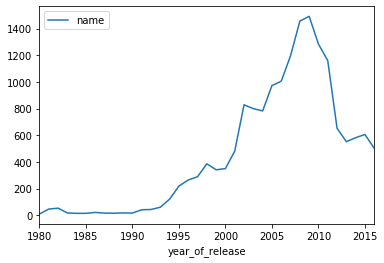

In [282]:
games.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count').plot()

По годовому распределению можно четко увидеть некоторые тенденции. С 1980 до 1993 можно видеть выпуск игр примерно на одном уровне. С 1994 года количество игр пошло вверх(связано может быть с бОльшим распростренением ПК), заканчивая пиком в 2009 году. После 2009 пошел спад. Возможно он связан с тем, что требования у играм стали серьезней(компьютеры становились мощнее и сделать  игру, которая бы соответствовала возможностям ПК, было уже сложнее). Еще одной причиной мог послужить мировой финансовый кризис, который затронул все отрасли, в том числе и прозводство игр. Безусловно данные по всем годам важны, так как по ним можно делать четкие выводы по поводу развития игровой индустрии.

- Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Построим график распределения с периодом пребывания на рынке каждой платформы.

In [283]:
platforms_years = games.pivot_table(index = 'year_of_release', values = 'name', columns = 'platform', aggfunc = 'count')

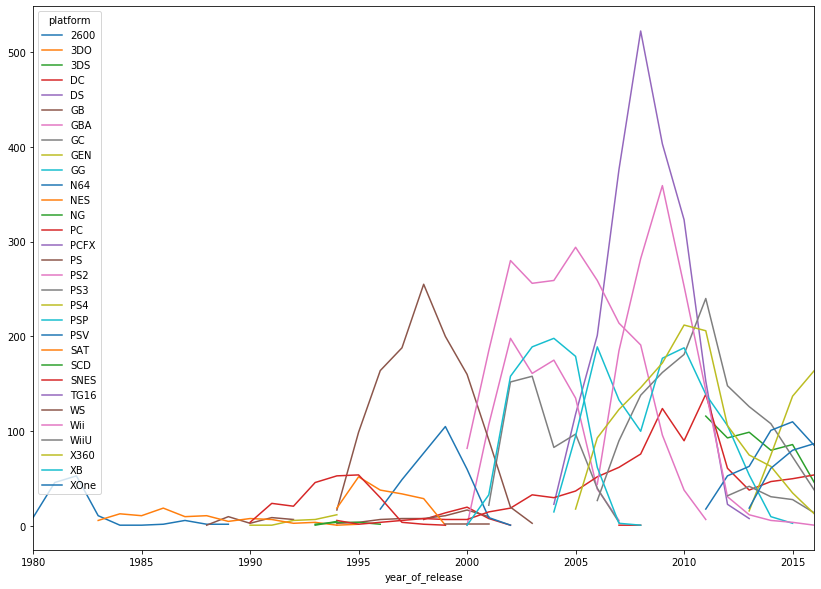

In [284]:
platforms_years.plot(figsize = (14,10))

По данному графику можно сделать вывод, что каждая платформа имеет определенный "срок годности", т.е. они актуальны на протяжении только конкретных периодов (за исключением *PC, PC* актуален всегда).

Теперь посмотрим, какие платформы находятся в топ 5 по количеству игр на них. 

In [285]:
top5_platforms = games.pivot_table(index = 'platform', values = 'name', aggfunc = 'count').sort_values(by = 'name', ascending = False).head().reset_index()

In [286]:
top5_platforms['platform']

0     PS2
1      DS
2     PS3
3     Wii
4    X360
Name: platform, dtype: object

Отфильтруем таблицу только для этих платформ.

In [287]:
games_top5_platforms = games[(games['platform'] == top5_platforms['platform'][0]) \
                             |(games['platform'] == top5_platforms['platform'][1]) \
                             |(games['platform'] == top5_platforms['platform'][2]) \
                             |(games['platform'] == top5_platforms['platform'][3]) \
                             |(games['platform'] == top5_platforms['platform'][4])]

Построим распределение топ 5 консолей.

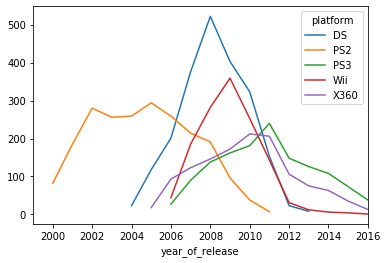

In [289]:
ax = games_top5_platforms.pivot_table(index = 'year_of_release', values = 'name', columns = 'platform', aggfunc = 'count').\
reset_index().plot(x = 'year_of_release',xlim = (1999,2016))

По этому графику можно сказать, что пока дольше всех на рынке держалась *PS2* и *X360*(11 лет), однако игры на *PS2* уже не выходят, а *X360* хоть и идет к своему концу, но может продержаться еще год другой.

Для того, чтобы оценить, сколько примерно на рынке будет существовать платформа, посмотрим, сколько игр выпускалось для каждой платформы.

In [290]:
games_number_of_games = games.pivot_table(index = 'platform', values = 'name', aggfunc = 'count').sort_values(by = 'name').reset_index()
games_number_of_games

,platform,name
0,GG,1
1,PCFX,1
2,TG16,2
3,3DO,3
4,WS,6
5,SCD,6
6,NG,12
7,GEN,27
8,DC,52
9,GB,98


На мой взгляд, все платформы, где количество игр 27 и меньше можно удалить, потому что такие платформы не совсем подходят для анализа нынешней ситуации.

In [291]:
odd_platforms = games_number_of_games[games_number_of_games['name'] < 28]['platform'].tolist()
odd_platforms

['GG', 'PCFX', 'TG16', '3DO', 'WS', 'SCD', 'NG', 'GEN']

Сформируем таблицу без этих платформ.

In [292]:
games_without_odd_platforms = games[~games['platform'].isin(odd_platforms)]
games_without_odd_platforms

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


На основании этой таблицы построим сводную таблицу с количеством лет, когда на нее выходили игры.

In [293]:
not_odd_platforms = games_without_odd_platforms.pivot_table(index = 'platform', values = 'year_of_release', aggfunc = 'nunique').sort_values(by='year_of_release')
not_odd_platforms

,platform,year_of_release
platform,,
XOne,1,4
PS4,1,4
WiiU,1,5
3DS,1,6
SAT,1,6
PSV,1,6
DC,1,7
GC,1,7
N64,1,7


Данная таблица сформирована из платформ, на которые выходило достаточное на мой взгляд количество игр. В ней мы можем видеть платформы, которым не удалось закрепиться на рынке, платформы, которые недавно вышли на рынок либо платформы, которые уже давно вышли держатся на плаву. Мы точно не можем знать, какой будет будущая платформа, поэтому, логично взять медианное значение из этой таблицы, чтобы дать оценку для количества лет платформы.

In [294]:
not_odd_platforms['year_of_release'].median()

10.0

Для того, чтобы понять за какой характерный срок появляются новые и исчезают старые платформы, построим распрделение количества платформ в различные года.

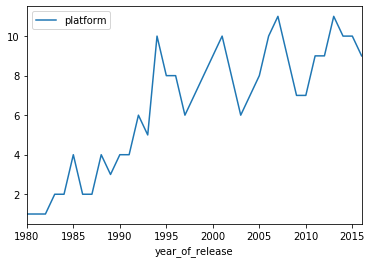

In [295]:
games.groupby('year_of_release')['platform'].nunique().reset_index().plot(x= 'year_of_release')

Судя по графику, можно говорить о определенных тенденциях на рынке платформ, начиная с 1994 года количество платформ уменьшается, а потом увеличивается до максимума за примерно один и тот же период (1994-2001, 2001-2007, 2007 - 2013). В среднем уходило 6-7 лет на то, чтобы с пикового значения, количество уходило резко вниз, а затем опять поднималось в пик.

- Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Взглянем еще раз на данные по количеству выпущенных игр в каждом году.

In [296]:
games.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')

,name
year_of_release,
1980,9
1981,46
1982,53
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


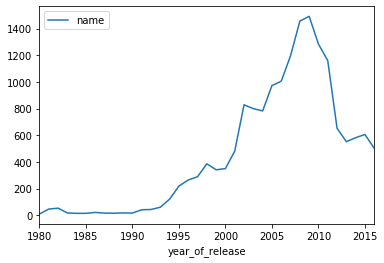

In [297]:
games.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count').plot()

Чтобы выделить актуальный период, надо понять, где начинается тот период, когда игр выходило уже не так мало, чтобы цифры были примерно в одном диапозоне на протияжении всего периода. На мой взгляд, начало актуального периода можем взять в 2012 году.

- Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [298]:
actual_year = 2012

In [299]:
actual_year_games = games[games['year_of_release']>=actual_year]

Возьмем топ 7 платформ по выпуску на них игр за аткуальный период.

In [300]:
actual_year_games.pivot_table(index=  'platform', values = 'name', aggfunc = 'count').sort_values(by = 'name', ascending = False).reset_index()['platform'].head(7)

0     PS3
1     PSV
2     3DS
3     PS4
4    X360
5      PC
6    XOne
Name: platform, dtype: object

In [301]:
actual_platforms = actual_year_games.pivot_table(index=  'platform', values = 'name', aggfunc = 'count').sort_values(by = 'name', ascending = False).reset_index()['platform'].head(7)

Теперь взглянем на графики выпуска игр на каждую из топ 7 платформ за актуальный период.

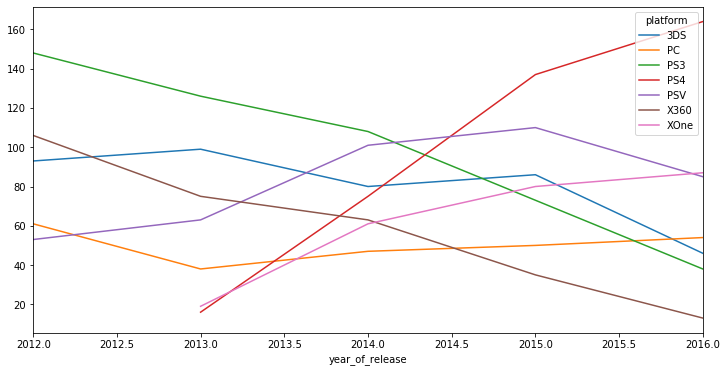

In [302]:
actual_year_games[(actual_year_games['platform'] == actual_platforms[0]) \
                  | (actual_year_games['platform'] == actual_platforms[1]) \
                  | (actual_year_games['platform'] == actual_platforms[2]) \
                  | (actual_year_games['platform'] == actual_platforms[3]) \
                  | (actual_year_games['platform'] == actual_platforms[4]) \
                  | (actual_year_games['platform'] == actual_platforms[5]) \
                  | (actual_year_games['platform'] == actual_platforms[6])].\
pivot_table(index = 'year_of_release', values = 'name', columns = 'platform', aggfunc = 'count').\
reset_index().plot(x = 'year_of_release', figsize= (12,6))

Исходя из этих графиков можно сделать вывод, что самая потенциально прибыльная платформа - *PS4*, у нее самый явный положительный тренд. Также небольшой рост показывают *PC* и *XOne*. Хуже всех обстоят дела у *X360*. На протяжении всего периода количество выпущенных игр стремится вниз, а в 2016 и вовсе подобралось близко к 0. Также отрицательная тенденция видится у *PSV, 3DS и PS3*.

- Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.

Для того, чтобы посмотреть разницу в продажах, посмотрим на сгруппированные результаты.

In [303]:
actual_year_games.groupby('platform')['name'].count().sort_values(ascending=False)

platform
PS3     493
PSV     412
3DS     404
PS4     392
X360    292
PC      250
XOne    247
PSP     173
WiiU    147
Wii      54
DS       31
Name: name, dtype: int64

Можно выделить лидера по продажам, заметно отличающегося от остальных - *PS3*, за ним идут три платформы с примерно одинаковыми показателями - *PSV, 3DS, PS4*. Самыми плохими являются *Wii* и *DS*. Можно говорить о том, что на данном отрезке времени величина в продажах довольно существена.

Теперь посмотрим на средние продажи на разных платформах. Для этого нарисуем boxplot.

(0, 3)

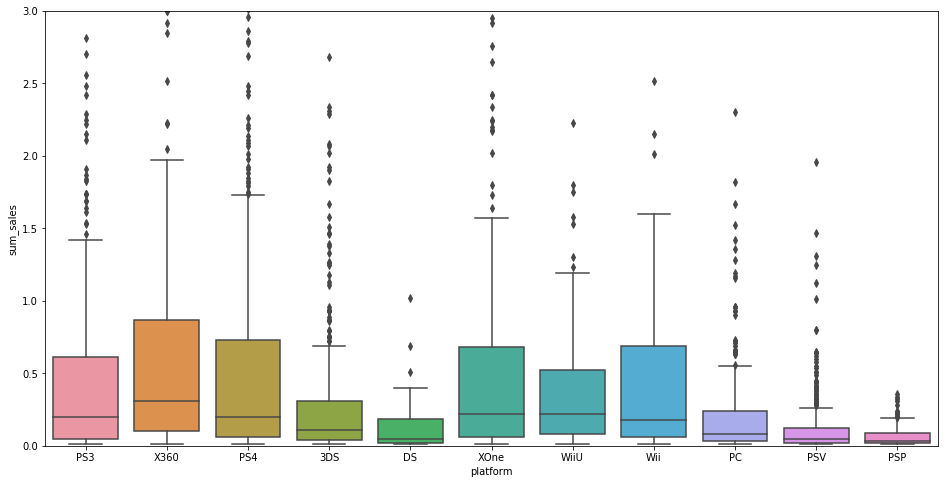

In [304]:
ax = plt.figure(figsize = (16,8))
sns.boxplot(data = actual_year_games, x = 'platform', y = 'sum_sales')
plt.ylim(0,3)

В среднем по продажам для каждой платформы есть довольно сильные различия. Самый большой размах boxplota у *X360*, самый низкий - у *PSP* и их результаты сильно отличаются. Получившиеся результаты можно разделить на две группы по величине размаха boxplotа - большие - *PS3, X360, PS4, XOne, WiiU, Wii* и маленькие - *3DS, DS, PC, PSV, PSP*.

Разница между платформами может формироваться засчет времени, когда эта платформа была популярна. Засчет инфляции, цена на один и тот же продукт каждый год становится больше. Поэтому, чем раньше была выпущена платформа, тем меньше была цена на игры и тем меньше ее продажи.

- Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

В качестве популярной платформы возьмем *PS3* (самый высокий показатель продаж за актуальный период).

In [305]:
games_ps3 = games[games['platform'] == 'PS3']

Диаграмма рассеяния и коэффициент корреляции между продажами и оценкой критиков.

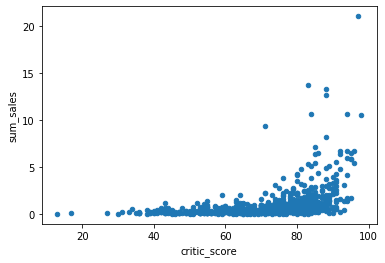

In [306]:
games_ps3.plot(x='critic_score', y='sum_sales', kind='scatter')

In [307]:
games_ps3['sum_sales'].corr(games_ps3['critic_score'])

0.43243156856420606

Диаграмма рассеяния и коэффициент корреляции между продажами и оценкой пользователей.

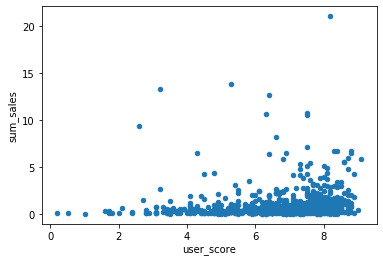

In [308]:
games_ps3.plot(x='user_score', y='sum_sales', kind='scatter')

In [309]:
games_ps3['sum_sales'].corr(games_ps3['user_score'])

0.12669133936341712

Глядя на диаграмму рассеяния и коэффициент корреляции для оценки критиков, можно сделать вывод, что положительная связь есть(на графике видно, что количество игр с большими продажами больше там, где оценка критиков тоже большая).

Если же взять диаграмму рассеяния и коэффициент корреляции для оценки критиков, то здесь свзяь не такая очевидная. Количество игр с большими продажами хоть и становится больше с увеличиением оценки, но не настолько, чтобы можно было говорить об устойчивой связи. Об этом говорит и коэффициент корреляции.

Этот результат можно объяснить тем, что люди больше доверяют оценкам экспертов, чем себе подобным. Это логично, ведь экперты более вдумчиво анализируют игры, чем простые пользователи.

- Соотнесите выводы с продажами игр на других платформах.

Для примера посмотрим на то, как обстоят дела у самой перспективной платформы на данный момент - *PS4* и самой "угасающей" платформы на данный момент - *X360*.

In [310]:
def critic_users_corr(data):
    data.plot(x='critic_score', y='sum_sales', kind='scatter')
    print('Коэффициент корреляции между оценками критиков и общими продажами: ', data['sum_sales'].corr(data['critic_score']))
    data.plot(x='user_score', y='sum_sales', kind='scatter')
    print('Коэффициент корреляции между оценками пользователей и общими продажами: ', data['sum_sales'].corr(data['user_score']))

In [311]:
games_ps4 = games[games['platform'] == 'PS4']
games_x360 = games[games['platform'] == 'X360']

Коэффициент корреляции между оценками критиков и общими продажами:  0.406567902061781
Коэффициент корреляции между оценками пользователей и общими продажами:  -0.031957110204556424


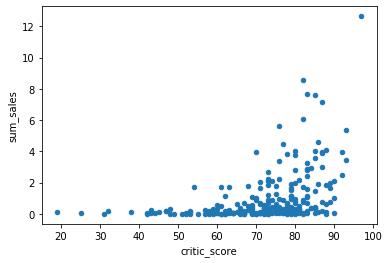

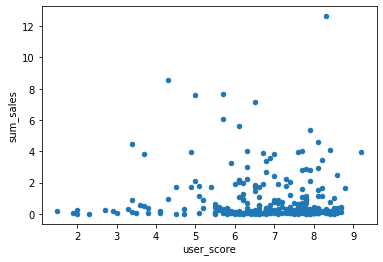

In [312]:
critic_users_corr(games_ps4)

Коэффициент корреляции между оценками критиков и общими продажами:  0.3937358653072588
Коэффициент корреляции между оценками пользователей и общими продажами:  0.11445882978454186


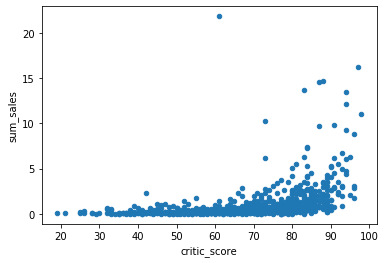

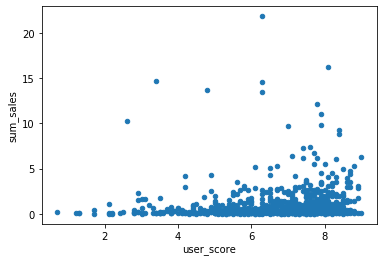

In [313]:
critic_users_corr(games_x360)

Теперь посмотрим на распределение и коэффициент для всех платформ за актуальный период.

Коэффициент корреляции между оценками критиков и общими продажами:  0.30829029587247037
Коэффициент корреляции между оценками пользователей и общими продажами:  0.004817442237192994


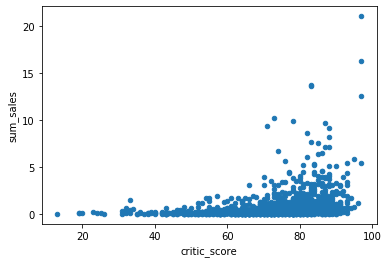

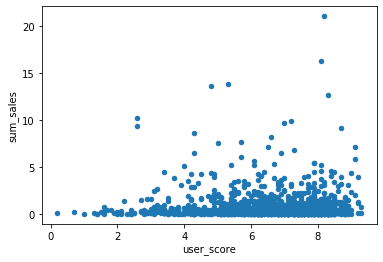

In [314]:
critic_users_corr(actual_year_games)

Можем увидеть, что как для отдельных платформ, так и для всех вместе взятых, результаты довольно похожи друг на друга, поэтому можно сказать, что зависимости между платформой и коэффициентом корреляции между оценкой и суммарной продажей нет.

- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Посмотрим на общее распределение игр по жанрам.

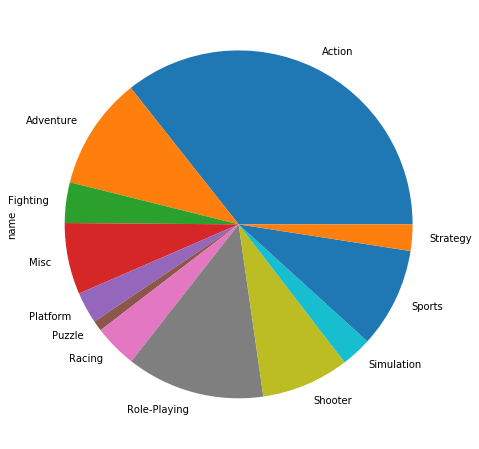

In [315]:
actual_year_games.groupby('genre').count()['name'].plot.pie(y='genre', figsize=(8, 8))

Видно, что бОльшую часть составляют игры категории *action*, затем идут *adventure*, *sports* и *role-playing* c примерно одинаковыми долями.

Для того, чтобы посмотреть на прибыльность жанров, построим boxplot суммарных сборов для игры каждого жанра.

(0, 3)

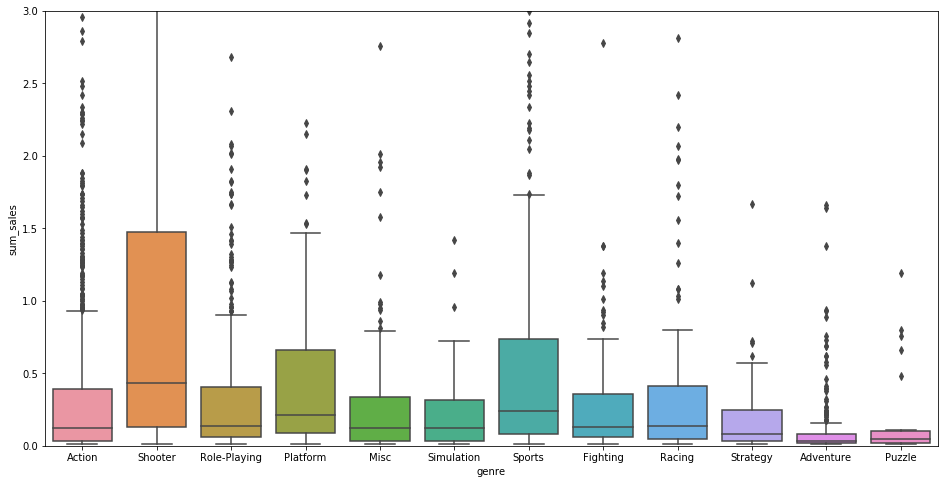

In [316]:
ax = plt.figure(figsize = (16,8))
sns.boxplot(data = actual_year_games, x = 'genre', y = 'sum_sales')
plt.ylim(0,3)

Можно увидеть, что очень сильно по средним продажам выделяется жанр *Shooter*. Также большие значения наблюдаются в жанрах *Platform* и *Sport*. С позиции малых продаж можно выделить два жанра - *Adventure* и *Puzzle*. 

### Вывод

В данном шаге был проведен исследовательский анализ данных и были получены следующие результаты:
- количество выпущенных игр росло каждый год, достигнув пика в 2012 году(1457 игр), после этого начало каждый год падать
- нашли тот год, начиная с которого можно строить различные модели, актуальные и сегодня (2012)
- самая перспективная платформа на данный момент - *PS4*, а лидер по  продажам - *PS3*
- самые большие средние продажи у платформы *X360*, самые мальенькие у *PSP*
- отзывы критиков влияют на продажи намного сильнее, чем отзывы пользователей.


### Шаг 4. Составьте портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.

NA:

In [317]:
NA_platforms = actual_year_games.groupby('platform').sum()['na_sales'].sort_values(ascending = False)

In [318]:
NA_platforms.head()

platform
X360    140.05
PS4     108.74
PS3     103.38
XOne     93.12
3DS      56.15
Name: na_sales, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6426a23250>],
      dtype=object)

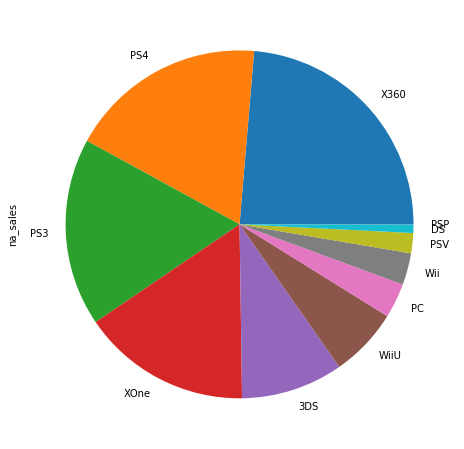

In [319]:
NA_platforms.plot.pie(figsize=(8, 8), subplots=True)

EU:

In [320]:
EU_platforms = actual_year_games.groupby('platform').sum()['eu_sales'].sort_values(ascending = False)

In [321]:
EU_platforms.head()

platform
PS4     141.09
PS3     106.86
X360     74.52
XOne     51.59
3DS      42.85
Name: eu_sales, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6426b30110>],
      dtype=object)

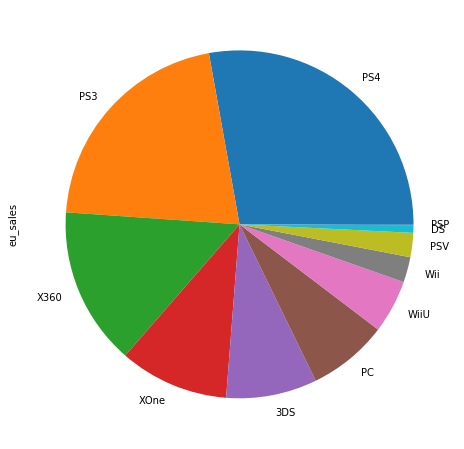

In [322]:
EU_platforms.plot.pie(figsize=(8, 8), subplots=True)

JP:

In [323]:
JP_platforms = actual_year_games.groupby('platform').sum()['jp_sales'].sort_values(ascending = False)

In [324]:
JP_platforms.head()

platform
3DS     87.84
PS3     35.29
PSV     21.11
PS4     15.96
WiiU    13.01
Name: jp_sales, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6426a8ed90>],
      dtype=object)

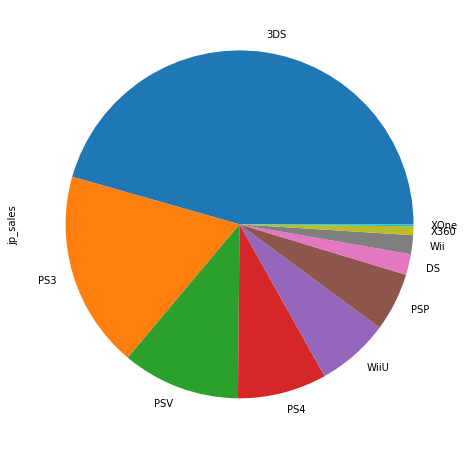

In [325]:
JP_platforms.plot.pie(figsize=(8, 8), subplots=True)

По результатам можно сделать несколько выводов:
- В каждом регионе свой лидер среди платформ по популярности. Для Северной Америки это X360, для Европы - PS4, а для Азии - 3DS. Причем интересен тот факт, что если в Америке и Европе 3DS находится лишь на 5 месте по популярности, то в Японии он забирает себе почти 50% всего рынка.
- Рынок платформ в Европе и Америке довольно похож(их топ-5 состоят из одних и тех же платформ).
- Японский рынок может отличаться от других засчет культурных особенностей и хорошего развития игровой промышленности. У них есть довольно много местных платформ и игр, которые будут иметь спрос только на внутреннем рынке.

- Самые популярные жанры (топ-5). Поясните разницу.

In [326]:
actual_year_games.groupby('genre').sum()['na_sales'].sort_values(ascending = False).head()

genre
Action          178.02
Shooter         144.81
Sports           81.53
Role-Playing     64.11
Misc             38.19
Name: na_sales, dtype: float64

In [327]:
actual_year_games.groupby('genre').sum()['eu_sales'].sort_values(ascending = False).head()

genre
Action          159.53
Shooter         113.49
Sports           69.09
Role-Playing     48.58
Racing           27.29
Name: eu_sales, dtype: float64

In [328]:
actual_year_games.groupby('genre').sum()['jp_sales'].sort_values(ascending = False).head()

genre
Role-Playing    65.54
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44
Name: jp_sales, dtype: float64

Здесь мы снова можем заметить, что Европа и Америка довольно похожи в своих предпочтениях(топ - 5 отличается только последней позицией). В то время как у Японии лидером является *Role-Playing*, занимающий 4 место в Европе и Америке. Это объясняется культурными различиями регионов. В Юго-Восточной Азии традиционно популярны игры жанра *RPG*. Нахождение *fighting* в топ-5 можно объяснить тем, что в Японии это популярный жанр и большинство игр этого жанра производится именно там. Рынок Японии может так отличаться засчет культурных особенностей страны и хорошего качества производителей игр, которые употребляют внутренний спрос, но не ориентирован на внешний рынок.

- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Для того, чтобы ответить на этот вопрос, нужно сделать из рейтинга ESRB количественную переменную, а не качественную. Для этого расставим рейтинг в порядке возрастания ограничений и присвоим цифры от 0.

In [329]:
actual_year_games['rating'].unique()

array(['M', nan, 'E', 'E10+', 'T'], dtype=object)

M - «Для взрослых», E - «Для всех», E10+ - «Для всех от 10 лет и старше», T - Подросткам(от 13 и старше).

Следовательно, E будет соответствовать 0, Е10+ - 1, T - 2, M - 3.

Напишем функцию, чтобы можно было представить данные значения рейтинга в числах.

In [330]:
def num_rating(rating):
    if rating == 'E':
        return 0
    elif rating == 'E10+':
        return 1
    elif rating == 'T':
        return 2
    elif rating == 'M':
        return 3
    else: return None

In [331]:
actual_year_games['num_rating'] = actual_year_games['rating'].apply(num_rating)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Посмотрим на коэффициенты корреляции.

In [332]:
actual_year_games['na_sales'].corr(actual_year_games['num_rating'])

0.08961354603454125

In [333]:
actual_year_games['eu_sales'].corr(actual_year_games['num_rating'])

0.060242491187374576

In [334]:
actual_year_games['jp_sales'].corr(actual_year_games['num_rating'])

-0.035002129802532866

По полученным коэффициентам корреляции можно сказать, что продажи во всех отмеченных регионах не зависят от возрастного рейтинга, поскольку коэффициенты корреляции показали очень слабую зависимость либо отсутствие таковой.

### Вывод

В данном шаге мы работали отдельно с тремя регионами и сопостовляли их между собой по различным критериям. Вот какие результаты были получены:
- рейтинг популярных платформ в Европе и Америке очень похож, их топ - 5 состоят из одинаковых платформ. В Японии лидирует платформа, которая в Европе и Америке занимает только 5 место
- рейтинг самых популярных жанров Европы и Америки также очень сильно похож. Первые 4 места одинаковы что там, что там. В Японии же мы видим лидером продаж жанр, находящийся на 4 месте в рейтингах Америки и Европы(*RPG*).
- исходя из имеющихся у нас данных, нельзя утверждать, что рейтинг ESRB влияет на продажи в любом из рассмотренных нами регионов.
- различия между регионами могут быть объяснены теми же причинами, что и в предыдущих пунктах - сильной культурной особенностью Японии и хорошего качества внутренних производителей, которые удовлетворяют спрос рынка. Поэтому влияние иностранной продукции на Японию не так сильно, как на другие регионы. Поэтому их портрет отличается от остальных.

### Шаг 5. Проверьте гипотезы

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Сформулируем нулевую гипотезу: средние пользовательские рейтинги платформ *Xbox One* и *PC* равны. Альтернативная: средние пользовательские рейтинги платформ *Xbox One* и *PC* не равны.

Сформируем выборки из игр на платформе XOne и PC.

In [335]:
actual_year_games_XOne = actual_year_games[actual_year_games['platform'] == 'XOne']
actual_year_games_PC = actual_year_games[actual_year_games['platform'] == 'PC']

Для того, чтобы опровергнуть нулевую гипотезу или не опровергнуть ее, воспользуемся scipy.stats.ttest_ind. Мы используем этот метод потому что есть две выборки из двух генеральных совокупностей.

In [336]:
np.var(actual_year_games_XOne['user_score'])

1.8965188383045526

In [337]:
np.var(actual_year_games_PC['user_score'])

2.7569952398906588

Дисперсии отличаются несильно, поэтому можем принять параметр equal_var = True

In [338]:
alpha = 0.05
actual_year_games_XOne_users = actual_year_games_XOne['user_score'].dropna().tolist()
actual_year_games_PC_users = actual_year_games_PC['user_score'].dropna().tolist()

In [339]:
results = st.ttest_ind(
    actual_year_games_XOne_users, 
    actual_year_games_PC_users,
    equal_var = True)

In [340]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


По полученным результатам можно сделать вывод, что при условии, что нулевая гипотеза верна, получить наблюдаемый или ещё более далёкий от предполагаемого результат можно с вероятностью 0.5535080500643661. Это вероятность выше 0.05, поэтому у нас нет оснований отвергнуть нулевую гипотезу.

- Средние пользовательские рейтинги жанров *Action* (англ. «действие», экшен-игры) и *Sports* (англ. «спортивные соревнования») разные.

Сформируем выборки из игр жанра *Action* и *Sports*.

In [341]:
actual_year_games_action = actual_year_games[actual_year_games['genre'] == 'Action']
actual_year_games_sports = actual_year_games[actual_year_games['genre'] == 'Sports']

Для того, чтобы опровергнуть нулевую гипотезу или не опровергнуть ее, воспользуемся scipy.stats.ttest_ind. Мы используем этот метод потому что есть две выборки из двух генеральных совокупностей.

In [342]:
np.var(actual_year_games_action['user_score'])

1.8820750539012878

In [343]:
np.var(actual_year_games_sports['user_score'])

3.0073882971729127

Дисперсии отличаются сильно, поэтому можем принять параметр equal_var = False.

In [344]:
alpha = 0.05
actual_year_games_action_users = actual_year_games_action['user_score'].dropna().tolist()
actual_year_games_sports_users = actual_year_games_sports['user_score'].dropna().tolist()

In [345]:
results = st.ttest_ind(
    actual_year_games_action_users, 
    actual_year_games_sports_users,
    equal_var = False)

In [346]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.305337670692197e-20
Отвергаем нулевую гипотезу


По полученным результатам можно сделать вывод, что при условии, что нулевая гипотеза верна, получить наблюдаемый или ещё более далёкий от предполагаемого результат можно с вероятностью 3.517102771333629e-26. Это вероятность сильно ниже 0.05, поэтому у нас есть основания отвергнуть нулевую гипотезу.

### Вывод

В данном шаге были проверены две гипотезы.
- средние пользовательские рейтинги платформ *Xbox One* и *PC* одинаковые. Использовав t-тест, мы не имели причин отвергнуть нулевую гипотезу.
- средние пользовательские рейтинги жанров *Action* (англ. «действие», экшен-игры) и *Sports* (англ. «спортивные соревнования») разные. Использовав t-тест, мы имели причины отвергнуть нулевую гипотезу.

### Шаг 6. Напишите общий вывод

В данной работе был проведен анализ выборки с информацией по продажам, оценкам игр. В ходе работы были:
- подкорректированы данные (заполнены пропуски, где возможно, изменены типы данных, приведены к нижнему регистру названия столбцов)
- на основе анализа данных сделаны выводы:
 - количество выпущенных игр росло каждый год, достигнув пика в 2012 году(1457 игр), после этого начало каждый год падать
 - нашли тот год, начиная с которого можно строить различные модели, актуальные и сегодня (2012)
 - самая перспективная платформа на данный момент - *PS4*, а лидер по продажам - *PS3*
 - самые большие средние продажи у платформы *X360*, самые мальенькие у *PSP*
 - отзывы критиков влияют на продажи намного сильнее, чем отзывы пользователей.
- сгруппированы данные на основе продаж в регионах и выявлены следующие результаты:
 - рейтинг популярных платформ в Европе и Америке очень похож, их топ - 5 состоят из одинаковых платформ. В Японии лидирует платформа, которая в Европе и Америке занимает только 5 место
  - рейтинг самых популярных жанров Европы и Америки также очень сильно похож. Первые 4 места одинаковы что там, что там. В Японии же мы видим лидером продаж жанр, находящийся на 4 месте в рейтингах Америки и Европы(*RPG*).
  - исходя из имеющихся у нас данных, нельзя утверждать, что рейтинг ESRB влияет на продажи в любом из рассмотренных нами регионов.
- проверены две гипотезы:
 - средние пользовательские рейтинги платформ *Xbox One* и *PC* одинаковые(нет оснований отвергнуть эту гипотезу)
 - средние пользовательские рейтинги жанров *Action* (англ. «действие», экшен-игры) и *Sports* (англ. «спортивные соревнования») разные(есть основания отвергунть нулевую гипотезу).